<div class="alert alert-block alert-info">
__Name__: pangenome_hyperopt<br/>
__Description__: Try automated search for classifier and optimum hyper-parameters<br/>
__Author__: Matthew Whiteside matthew dot whiteside at canada dot ca<br/>
__Date__: Oct 11, 2017<br/>
__TODO__:<br/>
</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [143]:
# Load external libs
from hpsklearn import HyperoptEstimator, any_classifier, xgboost_classification, random_forest, gradient_boosting, extra_trees
from hyperopt import tpe
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10.0,8.0]

In [6]:
# Load data
import os
os.chdir('../pangenome')
import config
import utils
import classify
pg, genome_list, locus_list = utils.read_panseq(config.PANSEQ['pangenome_file'])
amr,amr_list = utils.read_amr(config.PHENOTYPE['amr_file'], genome_list)
annot = utils.read_annot(config.ANNOTATION['blast_file'])

In [7]:
# Split into train & test for ampicillin
d = np.argwhere(amr_list == 'ampicillin').item(0)
validrows = ~np.isnan(amr[:,d])
validrows
X = pg[validrows,:]
y = amr[validrows,d]

test_size = int( 0.2 * len( y ) )
np.random.seed( 21 )
indices = np.random.permutation(X.shape[0])
X_train = X[ indices[:-test_size] ]
y_train = y[ indices[:-test_size] ]
X_test = X[ indices[-test_size:] ]
y_test = y[ indices[-test_size:] ]

In [8]:
# Define loss function
def loss_fn(y_target, y_prediction):
    return 1.0 - f1_score(y_target, y_prediction)

In [12]:
# HP search for Random Forest
rfc = HyperoptEstimator( classifier=random_forest('rfc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
rfc.fit( X_train.toarray(), y_train )
print( rfc.score( X_test.toarray(), y_test ) )
print( rfc.best_model() )
predictions = rfc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

0.941176470588
{'learner': RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None,
            max_features=0.344782910872078, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=67, n_jobs=1, oob_score=False, random_state=0,
            verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}


NameError: name 'classification_report' is not defined

In [18]:
predictions = rfc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

        0.0       0.82      0.93      0.87        15
        1.0       0.98      0.94      0.96        53

avg / total       0.95      0.94      0.94        68



In [15]:
etc = HyperoptEstimator( classifier=extra_trees('etc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
etc.fit( X_train.toarray(), y_train )
print( etc.score( X_test.toarray(), y_test ) )
print( etc.best_model() )
predictions = etc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

0.955882352941
{'learner': ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=0.9043349350446708,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=347, n_jobs=1,
           oob_score=False, random_state=1, verbose=False,
           warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
             precision    recall  f1-score   support

        0.0       0.88      0.93      0.90        15
        1.0       0.98      0.96      0.97        53

avg / total       0.96      0.96      0.96        68



In [16]:
gbc = HyperoptEstimator( classifier=gradient_boosting('gbc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
gbc.fit( X_train.toarray(), y_train )
print( gbc.score( X_test.toarray(), y_test ) )
print( gbc.best_model() )
predictions = gbc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

0.955882352941
{'learner': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.0765306839796841, loss='deviance',
              max_depth=None, max_features=0.8356287036892351,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=5, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=292,
              presort='auto', random_state=2, subsample=1.0, verbose=0,
              warm_start=False), 'preprocs': (), 'ex_preprocs': ()}
             precision    recall  f1-score   support

        0.0       0.88      0.93      0.90        15
        1.0       0.98      0.96      0.97        53

avg / total       0.96      0.96      0.96        68



In [17]:
xbc = HyperoptEstimator( classifier=xgboost_classification('xbc'), preprocessing=[], algo=tpe.suggest, loss_fn=loss_fn, trial_timeout=2000)
xbc.fit( X_train.toarray(), y_train )
print( xbc.score( X_test.toarray(), y_test ) )
print( xbc.best_model() )
predictions = xbc.predict( X_test.toarray() )
print(classification_report(y_test, predictions))

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.941176470588
{'learner': XGBClassifier(base_score=0.5, colsample_bylevel=0.7028641308580167,
       colsample_bytree=0.7980603649782954, gamma=0.003328636988102734,
       learning_rate=0.00990360535843554, max_delta_step=0, max_depth=10,
       min_child_weight=2, missing=nan, n_estimators=4400, nthread=-1,
       objective='binary:logistic', reg_alpha=0.0007025873903998169,
       reg_lambda=1.0246535683564084, scale_pos_weight=1, seed=1,
       silent=True, subsample=0.9738872114011073), 'preprocs': (), 'ex_preprocs': ()}
             precision    recall  f1-score   support

        0.0       0.82      0.93      0.87        15
        1.0       0.98      0.94      0.96        53

avg / total       0.95      0.94      0.94        68



In [40]:
# Examine feature importance
rfcb = rfc._best_learner
etcb = etc._best_learner
gbcb = gbc._best_learner
xbcb = xbc._best_learner

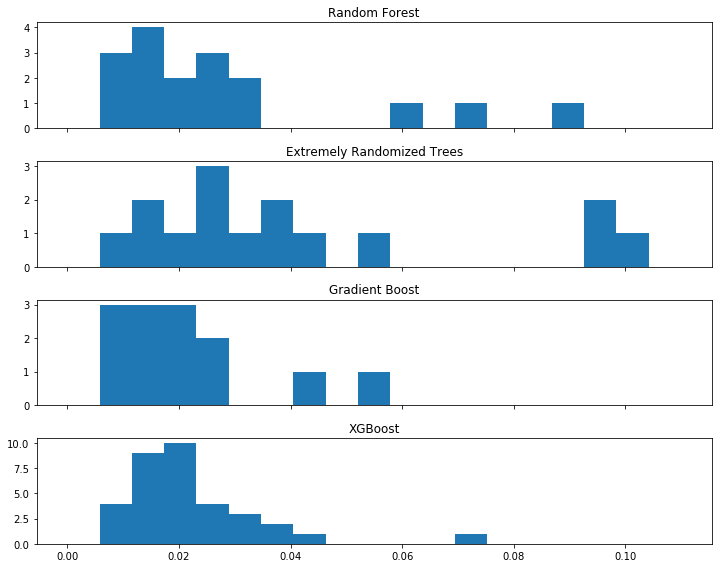

In [53]:
# Distributions
classify.histplot([rfcb.feature_importances_, etcb.feature_importances_, gbcb.feature_importances_, xbcb.feature_importances_], 
                  ['Random Forest','Extremely Randomized Trees', 'Gradient Boost', 'XGBoost'])

In [117]:
# Correlation between classifiers
importances = pd.DataFrame({'randomforest': rfcb.feature_importances_, 'extratrees': etcb.feature_importances_, 'gradientboost': gbcb.feature_importances_, 'xgboost': xbcb.feature_importances_},
            index=locus_list)

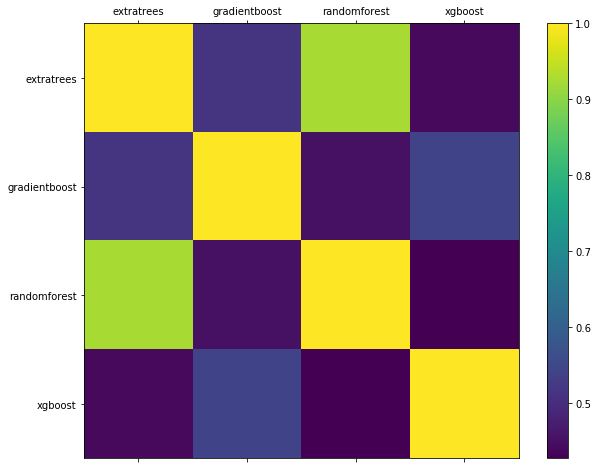

In [118]:
classify.corrplot(importances)

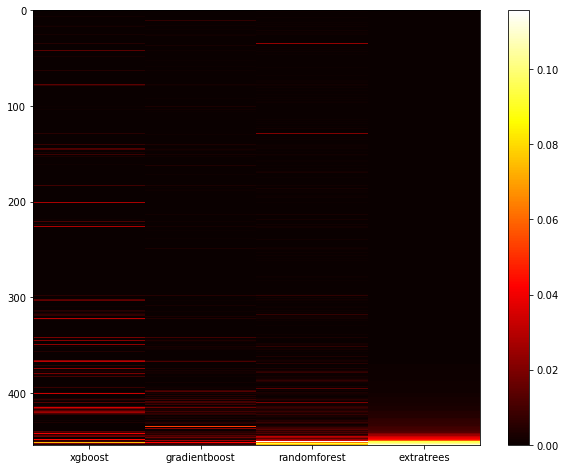

In [119]:
classify.heatplot(importances)

In [127]:
# Identify problematic features that result in FP/FN
test_genomes = genome_list[ indices[-test_size:] ]
xbpred = xbc.predict( X_test.toarray() )
xbfp = test_genomes[(y_test != xbpred) & (y_test == 0)]
xbfn = test_genomes[(y_test != xbpred) & (y_test == 1)]
confusion_matrix(y_test, xbpred)

array([[14,  1],
       [ 3, 50]])

In [130]:
gbpred = gbc.predict( X_test.toarray() )
gbfp = test_genomes[(y_test != gbpred) & (y_test == 0)]
gbfn = test_genomes[(y_test != gbpred) & (y_test == 1)]
confusion_matrix(y_test, gbpred)

array([[14,  1],
       [ 2, 51]])

In [131]:
etpred = etc.predict( X_test.toarray() )
etfp = test_genomes[(y_test != etpred) & (y_test == 0)]
etfn = test_genomes[(y_test != etpred) & (y_test == 1)]
confusion_matrix(y_test, etpred)

array([[14,  1],
       [ 2, 51]])

In [132]:
rfpred = rfc.predict( X_test.toarray() )
rffp = test_genomes[(y_test != rfpred) & (y_test == 0)]
rffn = test_genomes[(y_test != rfpred) & (y_test == 1)]
confusion_matrix(y_test, rfpred)

array([[14,  1],
       [ 3, 50]])

In [148]:
np.unique(np.concatenate((rffp,etfp,xbfp,gbfp)),return_counts=True)

(array(['85569_dot_218'], dtype=object), array([4]))

In [149]:
np.unique(np.concatenate((rffn,etfn,xbfn,gbfn)),return_counts=True)

(array(['85569_dot_216', '85569_dot_345', '85569_dot_44'], dtype=object),
 array([4, 4, 2]))

In [267]:
classify.bad_features('85569_dot_218', importances['randomforest'], X, y, locus_list, genome_list)

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,22599464615000,0.025051,1.632994,1.102762e-01,64,214,21,43
1,30132619115000,0.020070,0.027834,7.560859e-21,270,8,31,33
2,18079571711000,0.013371,0.000000,1.871345e-01,278,0,63,1
3,12053047863000,0.012225,0.497095,2.189518e-02,204,74,37,27
4,9039785910000,0.008302,0.000000,3.457324e-02,278,0,62,2
5,10546416756000,0.007662,0.134552,3.252811e-11,237,41,28,36
6,1506631131000,0.007006,0.000000,1.871345e-01,278,0,63,1
7,18079571529000,0.006855,0.376518,7.672327e-03,247,31,48,16
8,28625988412000,0.006501,2.893923,2.598339e-03,181,97,54,10
9,16572940550000,0.006345,0.032924,1.645657e-20,268,10,30,34


In [269]:
classify.bad_features('85569_dot_218', importances['extratrees'], X, y, locus_list, genome_list)

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,22599464615000,0.044990,1.632994,1.102762e-01,64,214,21,43
1,12053047721000,0.024886,0.370684,1.236340e-02,254,24,51,13
2,12053047863000,0.020398,0.497095,2.189518e-02,204,74,37,27
3,28625988412000,0.013362,2.893923,2.598339e-03,181,97,54,10
4,30132619347000,0.011084,0.000000,6.304531e-03,278,0,61,3
5,18079571711000,0.009990,0.000000,1.871345e-01,278,0,63,1
6,9039785910000,0.009702,0.000000,3.457324e-02,278,0,62,2
7,28625988224000,0.007366,0.054152,4.866696e-03,277,1,60,4
8,7533155036000,0.006941,0.683824,6.467122e-01,272,6,62,2
9,15066309621000,0.006636,0.395051,1.167988e-03,172,106,25,39


In [270]:
classify.bad_features('85569_dot_218', importances['gradientboost'], X, y, locus_list, genome_list)

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,15066309717000,0.019633,0.766734,3.962171e-01,170,108,35,29
1,30132619115000,0.010115,0.027834,7.560859e-21,270,8,31,33
2,30132619264000,0.009614,0.328930,1.081597e-04,199,79,29,35
3,12053047863000,0.008266,0.497095,2.189518e-02,204,74,37,27
4,19586202459000,0.007229,0.208042,2.603803e-04,264,14,51,13
5,10546416756000,0.006033,0.134552,3.252811e-11,237,41,28,36
6,28625988412000,0.004941,2.893923,2.598339e-03,181,97,54,10
7,25612726489000,0.004849,0.449011,9.229767e-03,219,59,40,24
8,16572940550000,0.004540,0.032924,1.645657e-20,268,10,30,34
9,12053047721000,0.004291,0.370684,1.236340e-02,254,24,51,13


In [271]:
classify.bad_features('85569_dot_218', importances['xgboost'], X, y, locus_list, genome_list)

/home/matt/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


,feature,importance,oddsratio,pvalue,resistant_with,resistant_without,susceptible_with,susceptible_without
0,22599464615000,0.043482,1.632994,1.102762e-01,64,214,21,43
1,12053047863000,0.040118,0.497095,2.189518e-02,204,74,37,27
2,15066309717000,0.028343,0.766734,3.962171e-01,170,108,35,29
3,30132619271000,0.028091,0.395463,4.426639e-03,233,45,43,21
4,22599464359000,0.027418,0.676008,2.088221e-01,209,69,43,21
5,1506631089000,0.025568,0.762246,3.313079e-01,162,116,33,31
6,4519892980000,0.022792,0.502703,1.481869e-02,185,93,32,32
7,6026523886000,0.021194,0.643343,1.241102e-01,165,113,31,33
8,30132619264000,0.019092,0.328930,1.081597e-04,199,79,29,35
9,1506631068000,0.019092,0.976947,1.000000e+00,214,64,49,15
